In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
rt_xls = pd.ExcelFile('Data/rpt.00013061.0000000000000000.RTMLZHBSPP_2011.xlsx')
print(rt_xls.sheet_names)

rt = pd.concat(
    (pd.read_excel(rt_xls, sheet_name=s) for s in rt_xls.sheet_names),
    ignore_index=True
)

rt

['Jan_1', 'Feb_2', 'Mar_3', 'Apr_4', 'May_5', 'Jun_6', 'Jul_7', 'Aug_8', 'Sep_9', 'Oct_10', 'Nov_11', 'Dec_12']


,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,Settlement Point Price
0,01/01/2011,1.0,1.0,N,HB_BUSAVG,SH,25.11
1,01/01/2011,1.0,2.0,N,HB_BUSAVG,SH,23.45
2,01/01/2011,1.0,3.0,N,HB_BUSAVG,SH,24.07
3,01/01/2011,1.0,4.0,N,HB_BUSAVG,SH,22.29
4,01/01/2011,1.0,1.0,N,HB_HOUSTON,HU,25.11
...,...,...,...,...,...,...,...
490556,12/31/2011,24.0,4.0,N,LZ_SOUTH,LZ,14.19
490557,12/31/2011,24.0,1.0,N,LZ_WEST,LZ,-0.84
490558,12/31/2011,24.0,2.0,N,LZ_WEST,LZ,-1.10
490559,12/31/2011,24.0,3.0,N,LZ_WEST,LZ,-1.57


In [3]:
zone = "LZ_HOUSTON"

rtm_z = rt[rt["Settlement Point Name"] == zone].copy()

In [4]:
rtm_z

,Delivery Date,Delivery Hour,Delivery Interval,Repeated Hour Flag,Settlement Point Name,Settlement Point Type,Settlement Point Price
32,01/01/2011,1.0,1.0,N,LZ_HOUSTON,LZ,25.11
33,01/01/2011,1.0,2.0,N,LZ_HOUSTON,LZ,23.45
34,01/01/2011,1.0,3.0,N,LZ_HOUSTON,LZ,24.07
35,01/01/2011,1.0,4.0,N,LZ_HOUSTON,LZ,22.29
88,01/01/2011,2.0,1.0,N,LZ_HOUSTON,LZ,22.33
...,...,...,...,...,...,...,...
490484,12/31/2011,23.0,4.0,N,LZ_HOUSTON,LZ,16.87
490537,12/31/2011,24.0,1.0,N,LZ_HOUSTON,LZ,18.98
490538,12/31/2011,24.0,2.0,N,LZ_HOUSTON,LZ,17.40
490539,12/31/2011,24.0,3.0,N,LZ_HOUSTON,LZ,16.98


In [5]:

mask_24 = rtm_z["Delivery Hour"] == 24
rtm_z.loc[mask_24, "Delivery Hour"] = 0
rtm_z.loc[mask_24, "Delivery Date"] = (
    pd.to_datetime(rtm_z.loc[mask_24, "Delivery Date"]) + pd.Timedelta(days=1)
).dt.strftime("%m/%d/%Y")

rtm_z["datetime"] = pd.to_datetime(
    rtm_z["Delivery Date"] + " " + rtm_z["Delivery Hour"].astype(int).astype(str),
    format="%m/%d/%Y %H"
)

rtm_z = rtm_z.set_index("datetime").sort_index()
rtm_z = rtm_z.rename(columns={"Settlement Point Price": "RTM_15min"})

rtm_hourly = rtm_z["RTM_15min"].groupby("datetime").mean().to_frame("RTM")

In [6]:
rtm_hourly

,RTM
datetime,
2011-01-01 01:00:00,23.7300
2011-01-01 02:00:00,22.1050
2011-01-01 03:00:00,21.3275
2011-01-01 04:00:00,20.9025
2011-01-01 05:00:00,21.6725
...,...
2011-12-31 20:00:00,22.7175
2011-12-31 21:00:00,20.3950
2011-12-31 22:00:00,17.9600


In [7]:

fed_funds_df = pd.read_csv('Data/federal_funds_2011.csv')
fed_funds_df

,observation_date,FEDFUNDS
0,1/1/2011,0.17
1,2/1/2011,0.16
2,3/1/2011,0.14
3,4/1/2011,0.10
4,5/1/2011,0.09
5,6/1/2011,0.09
6,7/1/2011,0.07
7,8/1/2011,0.10
8,9/1/2011,0.08
9,10/1/2011,0.07


In [8]:
fed_funds_rate = fed_funds_df
fed_funds_rate

,observation_date,FEDFUNDS
0,1/1/2011,0.17
1,2/1/2011,0.16
2,3/1/2011,0.14
3,4/1/2011,0.10
4,5/1/2011,0.09
5,6/1/2011,0.09
6,7/1/2011,0.07
7,8/1/2011,0.10
8,9/1/2011,0.08
9,10/1/2011,0.07


In [9]:

# columns: ['observation_date', 'FEDFUNDS']
fed_funds_rate['observation_date'] = pd.to_datetime(fed_funds_rate['observation_date'])
ffr_df = fed_funds_rate.set_index('observation_date').sort_index()

# start at first day of first month
start = ffr_df.index.min().normalize()               # 2011-01-01 00:00

# end = last day of last month, 23:00
last_month_end = ffr_df.index.max().to_period('M').to_timestamp('M')  # 2011-12-31 00:00
end = last_month_end + pd.Timedelta(hours=23)                          # 2011-12-31 23:00

# hourly index for the full year
hourly_idx = pd.date_range(start, end, freq='H')

# reindex and forward-fill monthly values
ffr_hourly = ffr_df.reindex(hourly_idx, method='ffill')

print(ffr_hourly.index[0], ffr_hourly.index[-1])
# 2011-01-01 00:00:00 2011-12-31 23:00:00
print(ffr_hourly.shape)

2011-01-01 00:00:00 2011-12-31 23:00:00
(8760, 1)


/tmp/ipykernel_669431/3828562517.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start, end, freq='H')


In [10]:
ffr_hourly = ffr_hourly[:-1]
ffr_hourly.shape

(8759, 1)

In [11]:
import netCDF4

temp = netCDF4.Dataset('Data/1yeartexasfocused/data_stream-oper_stepType-instant.nc')

cloud = netCDF4.Dataset('Data/1yeartexasfocused/6d54a8966bd3e929ebba9c39b86323fe.nc')

wind = netCDF4.Dataset('Data/1yeartexasfocused/b19d9b13a745c2fbd15c421befa61f76.nc')



In [12]:
lat = np.asarray(temp.variables['latitude'])
lon = np.asarray(temp.variables['longitude'])
# temperature 2 meters above ground level
t2m = np.asarray(temp.variables['t2m']) # shape (time, lat, lon)

cloud_cover = np.asarray(cloud.variables['tcc']) # shape (time, lat, lon)
v_component = np.asarray(wind.variables['v10']) # shape (time, lat, lon)
u_component = np.asarray(wind.variables['u10']) # shape (time, lat, lon)

In [13]:
# time is in hours (31 * 24 = 744 hours)
t2m = t2m[1:, :, :]  # last 744 hours of December 2010
cloud_cover = cloud_cover[1:, :, :]
v_component = v_component[1:, :, :]
u_component = u_component[1:, :, :]
print(t2m.shape)
print(cloud_cover.shape)
print(v_component.shape)
print(u_component.shape) 

(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)
(8759, 20, 36)


In [14]:
import numpy as np

# assuming u_component and v_component are already time × lat × lon
wind_speed = np.sqrt(u_component**2 + v_component**2)

print(wind_speed.shape)  # (time, lat, lon) same as u/v


(8759, 20, 36)


In [14]:
# # taking the sub grid of interest (around Texas)
# temp_sub = t2m[:, 208:257, 1006:1064]
# temp_sub.shape

temp_sub = t2m
print(temp_sub.shape)

(8759, 20, 36)


In [15]:
import yfinance as yf

data = yf.download(
    "SPY",
    start="2011-01-01",
    end="2012-01-01",
    interval="1d"
)
data


/tmp/ipykernel_666675/3138890543.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2011-01-03,97.480064,97.902052,96.444262,97.219194,138725200
2011-01-04,97.426376,97.725606,96.820242,97.694915,137409700
2011-01-05,97.932755,97.994137,97.027390,97.119463,133975300
2011-01-06,97.740952,98.078547,97.449396,97.971131,122519000
2011-01-07,97.549156,98.032526,96.789573,97.871403,156034600
...,...,...,...,...,...
2011-12-23,99.008163,99.039498,98.240479,98.444147,92187200
2011-12-27,99.086510,99.345018,98.749667,98.835837,86075700


In [16]:


# 2. Convert daily SPY data to hourly array of length 744


spy_daily = data["Close"]

idx = pd.date_range("2010-12-01", "2010-12-31 23:00", freq="H")



/tmp/ipykernel_666675/1288388696.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2010-12-01", "2010-12-31 23:00", freq="H")


In [17]:
spy_daily

Ticker,SPY
Date,
2011-01-03,97.480064
2011-01-04,97.426376
2011-01-05,97.932755
2011-01-06,97.740952
2011-01-07,97.549156
...,...
2011-12-23,99.008163
2011-12-27,99.086510
2011-12-28,97.786148


We now have said data: rtm - (744), fed funds - (744), spy - (744), t2m - (744, 49, 58). I would like to predict the average real time value of electricity on the last day.

In [18]:
rtm_hourly.shape

(8759, 1)

making it such that the weekend spy prices stay the same as the previous (market is closed on weekends)

In [19]:

spy_daily_full = spy_daily.asfreq("D").ffill()
idx = pd.date_range("2011-01-01", "2011-12-31", freq="D")
spy_daily_full = spy_daily.reindex(idx).ffill()

In [20]:
start = spy_daily_full.index.min()
end   = spy_daily_full.index.max()

idx_hourly = pd.date_range(start, end + pd.Timedelta(hours=23), freq="H")

spy_hourly = spy_daily_full.reindex(idx_hourly, method="ffill")[:-1]
spy_hourly.shape

/tmp/ipykernel_666675/2008773562.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_hourly = pd.date_range(start, end + pd.Timedelta(hours=23), freq="H")


(8759, 1)

In [21]:
print(rtm_hourly.shape)
print(spy_hourly.shape)

print(temp_sub.shape)
print(ffr_hourly.shape)

(8759, 1)
(8759, 1)
(8759, 20, 36)
(8759, 1)


Having a Model which preserves Spatial Dimensions of T2M

In [22]:
import numpy as np
import pandas as pd

T = rtm_hourly.shape[0]  # 744 for one month
feature_cols = ["RT", "SPY", "FFR", "hour", "dow", "month"]

idx = pd.date_range("2010-12-01", periods=T, freq="H")  # adjust start

df_scalar = pd.DataFrame(index=idx)
df_scalar["RT"]   = rtm_hourly.squeeze()
df_scalar["SPY"]  = spy_hourly.squeeze()
df_scalar["FFR"]  = ffr_hourly.astype("float32")

# calendar features
df_scalar["hour"]  = df_scalar.index.hour
df_scalar["dow"]   = df_scalar.index.dayofweek
df_scalar["month"] = df_scalar.index.month


/tmp/ipykernel_666675/1956707726.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range("2010-12-01", periods=T, freq="H")  # adjust start


In [ ]:
# grid_all = np.stack(
#     [temp_sub, cloud_cover, u_component, v_component],
#     axis=-1
# ).astype("float32")

grid_all = np.stack(
    [temp_sub, cloud_cover, wind_speed],
    axis=-1
).astype("float32")


print(grid_all.shape) 

(8759, 20, 36, 2)


In [ ]:
grid_mean = grid_all.mean(axis=(0, 1, 2), keepdims=True)  # (1,1,1,4)
grid_std  = grid_all.std(axis=(0, 1, 2), keepdims=True) + 1e-6
grid_all  = (grid_all - grid_mean) / grid_std

In [24]:
mask_valid = ~df_scalar[feature_cols + ["RT"]].isna().any(axis=1)
df_scalar = df_scalar[mask_valid]
grid_all = grid_all[mask_valid.to_numpy()]  # keep t2m in sync with time axis

In [25]:
df_scalar.head()

,RT,SPY,FFR,hour,dow,month
2011-01-03 00:00:00,21.6025,97.480064,0.17,0,0,1
2011-01-03 01:00:00,22.0175,97.480064,0.17,1,0,1
2011-01-03 02:00:00,21.3325,97.480064,0.17,2,0,1
2011-01-03 03:00:00,21.6450,97.480064,0.17,3,0,1
2011-01-03 04:00:00,22.2300,97.480064,0.17,4,0,1


In [26]:
past_hours = 24
future_hours = 24


def make_supervised_spatiotemporal(df_scalar, grid_all, past_hours, future_hours, feature_cols):
    # df_scalar: DataFrame (T, n_scalar)
    # t2m_grid:  array (T, H, W)
    values = df_scalar[feature_cols].to_numpy().astype("float32")  # (T, n_scalar)
    rt     = df_scalar["RT"].to_numpy().astype("float32")          # (T,)
    
    
    n_scalar   = values.shape[1]
    T, H, W, C = grid_all.shape
    
    X_grid_list = []
    X_seq_list  = []
    Y_list      = []

    # here we get samples by sliding a window over time (each step is a sample of data)
    
    for t in range(T - past_hours - future_hours + 1): # so we dont overshoot the time axis
        # temperature block
        grid_block = grid_all[t : t + past_hours]                # (past_hours, H, W)
        grid_block = grid_block[..., np.newaxis]                  # (past_hours, H, W, 1)
        
        # scalar time-series block
        seq_block = values[t : t + past_hours]                    # (past_hours, n_scalar)
        
        # future RT prices
        future_rt = rt[t + past_hours : t + past_hours + future_hours]  # (24,)
        
        X_grid_list.append(grid_block)
        X_seq_list.append(seq_block)
        Y_list.append(future_rt)
    
    X_grid = np.stack(X_grid_list, axis=0)   # (n_samples, past_hours, H, W, 1)
    X_seq = np.stack(X_seq_list, axis=0)    # (n_samples, past_hours, n_scalar)
    Y = np.stack(Y_list, axis=0)        # (n_samples, future_hours)
    
    return X_grid, X_seq, Y

X_grid, X_seq, Y = make_supervised_spatiotemporal(
    df_scalar, grid_all, past_hours, future_hours, feature_cols
)

print("X_grid:", X_grid.shape)  # (n_samples, 24, H, W, 1)
print("X_seq: ", X_seq.shape)   # (n_samples, 24, n_scalar)
print("Y:     ", Y.shape)       # (n_samples, 24)


X_grid: (7919, 24, 20, 36, 2, 1)
X_seq:  (7919, 24, 6)
Y:      (7919, 24)


In [27]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # in MB
    )

2025-12-02 13:37:45.013960: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 13:37:45.050978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 13:37:45.065293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 13:37:45.069563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 13:37:45.084150: I tensorflow/core/platform/cpu_feature_guar

In [28]:
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, BatchNormalization, GlobalAveragePooling2D, Flatten,
    Conv1D, GlobalAveragePooling1D, Dense, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

n_scalar = X_seq.shape[2]
H, W, C = X_grid.shape[2], X_grid.shape[3], X_grid.shape[4]

# spatio-temporal grid branch
grid_in = Input(shape=(past_hours, H, W, C), name="grid_input")
xg = ConvLSTM2D(
    filters=16,
    kernel_size=(3, 3),
    padding="same",
    activation="relu",
    return_sequences=False
)(grid_in)
xg = BatchNormalization()(xg)
xg = Flatten()(xg)
#xg = GlobalAveragePooling2D()(xg)   # -> (batch, 16)

# time series branch
seq_in = Input(shape=(past_hours, n_scalar), name="seq_input")
xs = Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu")(seq_in)
xs = Conv1D(filters=32, kernel_size=3, padding="causal", activation="relu")(xs)
xs = GlobalAveragePooling1D()(xs)   # -> (batch, 32)

# combine
x = Concatenate()([xg, xs])         # (batch, 48)
x = Dense(64, activation="relu")(x)
x = Dense(64, activation="relu")(x)
out = Dense(future_hours, name="output")(x)   # 24-hour forecast

model = Model(inputs=[grid_in, seq_in], outputs=out)
model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()


I0000 00:00:1764700667.497391  666675 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764700667.497510  666675 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764700667.497530  666675 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764700667.608741  666675 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-02 13:37:47.608783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ grid_input          │ (None, 24, 20,    │          0 │ -                 │
│ (InputLayer)        │ 36, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 20, 36,    │     10,432 │ grid_input[0][0]  │
│ (ConvLSTM2D)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 32)    │        608 │ seq_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 20, 36,    │         64 │ conv_lstm2d[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 32)    │      3,104 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 11520)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 11552)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    739,392 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 24)        │      1,560 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 759,320 (2.90 MB)

 Trainable params: 759,288 (2.90 MB)

 Non-trainable params: 32 (128.00 B)

In [29]:
split = int(len(X_grid) * 0.8)
Xg_train, Xg_test = X_grid[:split], X_grid[split:]
Xs_train, Xs_test = X_seq[:split],  X_seq[split:]
Y_train,  Y_test  = Y[:split],      Y[split:]

history = model.fit(
    [Xg_train, Xs_train], Y_train,
    validation_data=([Xg_test, Xs_test], Y_test),
    epochs=8,
    batch_size=4,
    verbose=1
)


Epoch 1/8


I0000 00:00:1764700671.660717  666838 service.cc:146] XLA service 0x5619a03c9c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764700671.660814  666838 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-12-02 13:37:51.756691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 13:37:52.208168: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   6/1584 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - loss: 240891.3438 - mae: 133.6058

I0000 00:00:1764700676.329537  666838 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1584/1584 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - loss: 34588.6875 - mae: 38.5564 - val_loss: 1870.9849 - val_mae: 25.8664
Epoch 2/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 33039.9648 - mae: 38.4182 - val_loss: 2761.4634 - val_mae: 37.6927
Epoch 3/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 55s 35ms/step - loss: 31013.1543 - mae: 36.4712 - val_loss: 1713.5702 - val_mae: 19.8722
Epoch 4/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - loss: 30810.3242 - mae: 36.6699 - val_loss: 1721.1110 - val_mae: 20.2568
Epoch 5/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - loss: 32854.3906 - mae: 37.9378 - val_loss: 2115.7097 - val_mae: 24.3500
Epoch 6/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - loss: 31439.5332 - mae: 37.8790 - val_loss: 1951.0026 - val_mae: 24.5211
Epoch 7/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - loss: 29660.1855 - mae: 35.4708 - val_loss: 2381.7493 - val_mae: 34.4910
Epoch 8/8
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 31927.2832 - mae: 38.2833 - val_loss:

In [31]:
last_grid_block = grid_all[-past_hours:]              # (24, H, W)
last_grid_block = last_grid_block[..., np.newaxis]   # (24, H, W, 1)

last_seq_block = df_scalar[feature_cols].to_numpy().astype("float32")[-past_hours:]

Xg_last = np.expand_dims(last_grid_block, axis=0)    # (1, 24, H, W, 1)
Xs_last = np.expand_dims(last_seq_block,  axis=0)    # (1, 24, n_scalar)

next_24_forecast = model.predict([Xg_last, Xs_last])[0]  # shape (24,)
print("Next 24-hour forecast:", next_24_forecast)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Next 24-hour forecast: [47.953186 49.51905  48.170475 44.54139  38.338974 44.5392   46.870827
 44.431995 42.726852 32.55742  34.745365 34.41779  31.669672 34.385014
 34.109535 35.768723 34.0592   32.467457 35.0417   41.565987 46.992756
 42.841892 44.3747   38.009445]


# Checking the actual values

In [ ]:
rt_2012_jan = pd.read_excel('Data/rpt.00013060.0000000000000000.DAMLZHBSPP_2012.xlsx', sheet_name='Jan_1')


In [ ]:
rt_2012_jan

,Delivery Date,Hour Ending,Repeated Hour Flag,Settlement Point,Settlement Point Price
0,01/01/2012,01:00,N,HB_BUSAVG,18.19
1,01/01/2012,01:00,N,HB_HOUSTON,18.44
2,01/01/2012,01:00,N,HB_HUBAVG,17.79
3,01/01/2012,01:00,N,HB_NORTH,18.49
4,01/01/2012,01:00,N,HB_SOUTH,18.40
...,...,...,...,...,...
10411,01/31/2012,24:00,N,LZ_LCRA,19.99
10412,01/31/2012,24:00,N,LZ_NORTH,19.99
10413,01/31/2012,24:00,N,LZ_RAYBN,19.99
10414,01/31/2012,24:00,N,LZ_SOUTH,20.01


In [ ]:
zone = "LZ_HOUSTON"
rtm_z = rt_2012_jan[rt_2012_jan["Settlement Point"] == zone].copy()
rtm_z


,Delivery Date,Hour Ending,Repeated Hour Flag,Settlement Point,Settlement Point Price
8,01/01/2012,01:00,N,LZ_HOUSTON,18.44
22,01/01/2012,02:00,N,LZ_HOUSTON,17.16
36,01/01/2012,03:00,N,LZ_HOUSTON,18.20
50,01/01/2012,04:00,N,LZ_HOUSTON,18.52
64,01/01/2012,05:00,N,LZ_HOUSTON,18.85
...,...,...,...,...,...
10354,01/31/2012,20:00,N,LZ_HOUSTON,27.16
10368,01/31/2012,21:00,N,LZ_HOUSTON,24.61
10382,01/31/2012,22:00,N,LZ_HOUSTON,22.39
10396,01/31/2012,23:00,N,LZ_HOUSTON,21.16


In [ ]:
rtm_z["Hour Ending"].str.split(":").str[0].astype(int)

8         1
22        2
36        3
50        4
64        5
         ..
10354    20
10368    21
10382    22
10396    23
10410    24
Name: Hour Ending, Length: 744, dtype: int64

In [ ]:
# 1. make Delivery Date a datetime
rtm_z["Delivery Date"] = pd.to_datetime(rtm_z["Delivery Date"], format="%m/%d/%Y")

# 2. find the 24:00 rows and shift them to next day at 00:00
mask_24 = rtm_z["Hour Ending"].str.strip().eq("24:00")

rtm_z.loc[mask_24, "Delivery Date"] = rtm_z.loc[mask_24, "Delivery Date"] + pd.Timedelta(days=1)
rtm_z.loc[mask_24, "Hour Ending"]   = "00:00"

# 3. build a proper datetime column
rtm_z["datetime"] = pd.to_datetime(
    rtm_z["Delivery Date"].dt.strftime("%m/%d/%Y") + " " + rtm_z["Hour Ending"],
    format="%m/%d/%Y %H:%M"
)

# now you can set as index and aggregate
rtm_z = rtm_z.set_index("datetime").sort_index()
rtm_z = rtm_z.rename(columns={"Settlement Point Price": "RTM_15min"})
rtm_hourly_true = rtm_z["RTM_15min"].groupby("datetime").mean().to_frame("RTM")

In [ ]:
rtm_hourly_true[:24]

,RTM
datetime,
2012-01-01 01:00:00,18.44
2012-01-01 02:00:00,17.16
2012-01-01 03:00:00,18.20
2012-01-01 04:00:00,18.52
2012-01-01 05:00:00,18.85
2012-01-01 06:00:00,19.84
2012-01-01 07:00:00,21.40
2012-01-01 08:00:00,21.96
2012-01-01 09:00:00,22.66


# Using a Random Forest Regressor

preparing data

In [ ]:
# rt_xls = pd.ExcelFile('Data/rpt.00013061.0000000000000000.RTMLZHBSPP_2010.xlsx')
# print(rt_xls.sheet_names)

# rt = pd.concat(
#     (pd.read_excel(rt_xls, sheet_name=s) for s in rt_xls.sheet_names),
#     ignore_index=True
# )


# zone = "LZ_HOUSTON"

# rtm_z = rt[rt["Settlement Point Name"] == zone].copy()


# mask_24 = rtm_z["Delivery Hour"] == 24
# rtm_z.loc[mask_24, "Delivery Hour"] = 0
# rtm_z.loc[mask_24, "Delivery Date"] = (
#     pd.to_datetime(rtm_z.loc[mask_24, "Delivery Date"]) + pd.Timedelta(days=1)
# ).dt.strftime("%m/%d/%Y")

# rtm_z["datetime"] = pd.to_datetime(
#     rtm_z["Delivery Date"] + " " + rtm_z["Delivery Hour"].astype(str),
#     format="%m/%d/%Y %H"
# )

# rtm_z = rtm_z.set_index("datetime").sort_index()
# rtm_z = rtm_z.rename(columns={"Settlement Point Price": "RTM_15min"})

# rtm_hourly = rtm_z["RTM_15min"].groupby("datetime").mean().to_frame("RTM")

In [ ]:
# #from cuml.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestRegressor

# T, H, W = temp_sub.shape

# # Flatten the spatial grid for each hour
# t2m_flat = temp_sub.reshape(T, H*W)          # (T, H*W)

# # Build a base hourly DataFrame with scalar features
# idx = pd.date_range("2010-12-01", periods=T, freq="H")
# df = pd.DataFrame(index=idx)
# df["RT"]   = rtm_hourly.squeeze()
# df["SPY"]  = spy_hourly.squeeze()
# df["FFR"]  = ffr
# df["hour"] = df.index.hour
# df["dow"]  = df.index.dayofweek
# df["month"]= df.index.month

# scalar_vals = df[["SPY", "FFR", "hour", "dow", "month"]].to_numpy()

# PAST_HOURS   = 24
# FUTURE_HOURS = 24

# X_list = []
# y_list = []

# # moving window for samples

# for t in range(T - PAST_HOURS - FUTURE_HOURS + 1):
#     # past 24h spatial grids (flattened)
#     past_grids = t2m_flat[t : t + PAST_HOURS]
#     # past 24h scalar features
#     past_scalars = scalar_vals[t : t + PAST_HOURS]

#     # flatten time + space + scalars into one feature vector
#     x = np.concatenate([
#         past_grids.reshape(-1),        # 24 * (H*W)
#         past_scalars.reshape(-1)       # 24 * n_scalar
#     ])
#     X_list.append(x)

#     # target = average RT over next day
#     future_rt = df["RT"].to_numpy()[t + PAST_HOURS : t + PAST_HOURS + FUTURE_HOURS]
#     y_list.append(future_rt)

# X = np.stack(X_list)   # (n_samples, n_features)
# y = np.array(y_list)   # (n_samples,)

# print(X.shape, y.shape)




In [ ]:

# split = int(0.8 * len(X))
# X_train, X_val = X[:split], X[split:]
# y_train, y_val = y[:split], y[split:]

# rf = RandomForestRegressor(
#     n_estimators=200,
#     max_depth=10,
#     random_state=0,
#     n_jobs=-1,
# )

# rf.fit(X_train, y_train)

# X_last = X[-1:]
# y_last_pred = rf.predict(X_last)
# print("Next 24-hour forecast (RF):", y_last_pred[0])

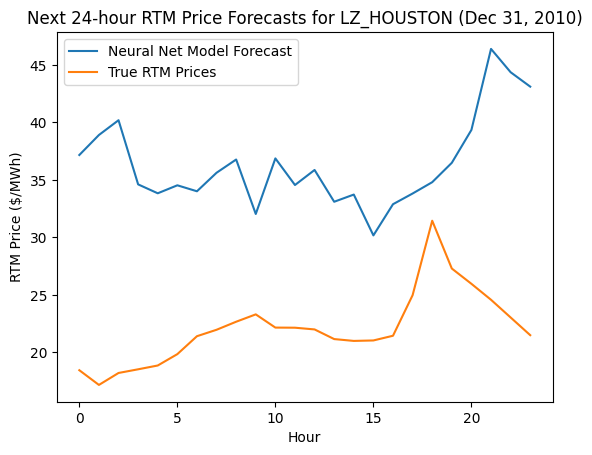

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(24), next_24_forecast, label="Neural Net Model Forecast")
#plt.plot(range(24), y_last_pred[0], label="Random Forest Model Forecast")
plt.plot(range(24), rtm_hourly_true[:24]["RTM"], label="True RTM Prices")
plt.xlabel("Hour")
plt.ylabel("RTM Price ($/MWh)")
plt.title("Next 24-hour RTM Price Forecasts for LZ_HOUSTON (Jan 1, 2011)")
plt.legend()
plt.show()